# Regression and Other Stories: Newcomb

Posterior predictive checking of Normal model for Newcomb’s speed of light data. See Chapter 11 in Regression and Other Stories.

In [3]:
import arviz as az
from bambi import Model
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
from scipy import stats
import statsmodels.formula.api as sm

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [6]:
newcomb = pd.read_csv("https://raw.githubusercontent.com/avehtari/ROS-Examples/master/Newcomb/data/newcomb.txt")
newcomb.head()

,y
0,28
1,26
2,33
3,24
4,34


### Histogram of the data

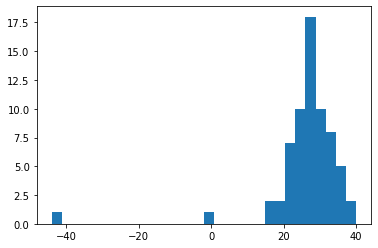

In [17]:
plt.hist(newcomb.values,bins=30);

### Histogram of data with arviz
Currently raising exception. Issue logged https://github.com/arviz-devs/arviz/issues/1306

In [18]:
# az.plot_dist(newcomb.values, hist_kwargs=dict(bins=30))

### Fit a regression model with just the intercept term

In [52]:
model = Model(newcomb)
fit_1 = model.fit('y ~ 1', samples=3000, chains=4)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_sd, Intercept]
INFO:pymc3:NUTS: [y_sd, Intercept]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 3 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 3 seconds.
The acceptance probability does not match the target. It is 0.8828610411316705, but should be close to 0.8. Try to increase the number of tuning steps.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
/opt/conda/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `f

### Simulate from the predictive distribution
TODO: Add in manual simulation. See below for r code

In [ ]:
"""
sims <- as.matrix(fit)
n_sims <- nrow(sims)
n <- length(newcomb$y)
y_rep <- array(NA, c(n_sims, n))
for (s in 1:n_sims)
    y_rep[s,] <- rnorm(n, sims[s,1], sims[s,2])
"""

### Simulate using built-in function

In [53]:
with model.backend.model:
    posterior_predictive = pm.sample_posterior_predictive(model.backend.trace)

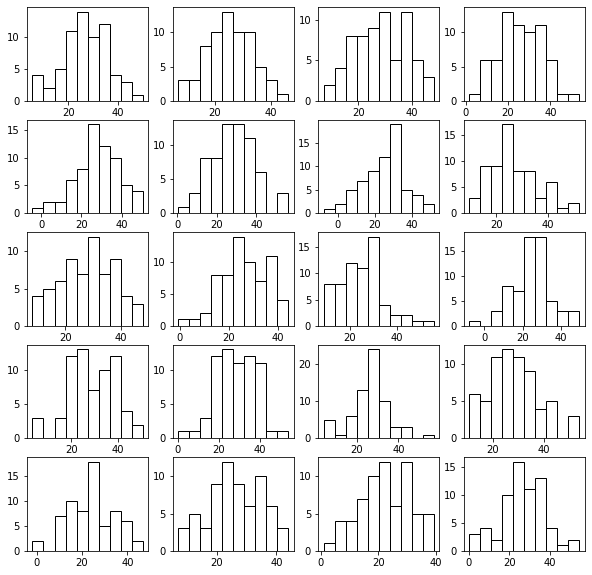

In [54]:
# Get 20 random row numbers
n_samples = 20
fig, axes = plt.subplots(5, 4, figsize=(10, 10))
row_nums = stats.randint(0, posterior_predictive["y"].shape[0]-1).rvs(n_samples)

for i, row_num in enumerate(row_nums):
    ax = axes.ravel()[i]
    ax.hist(posterior_predictive["y"][row_num], fill=False)

### Plot kernel density estimate of data and 100 replications using built-in function

Plot PPC does this in ArviZ although something is failing unfortunately
https://arviz-devs.github.io/arviz/generated/arviz.plot_ppc.html#arviz.plot_ppc

In [43]:
# Add Posterior Predictive object to Inference Data
az.concat(fit_1, az.from_dict(posterior_predictive=posterior_predictive), inplace=True)

/opt/conda/lib/python3.8/site-packages/arviz/data/base.py:141: UserWarning: More chains (4000) than draws (66). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


/opt/conda/lib/python3.8/site-packages/arviz/numeric_utils.py:58: UserWarning: kde plot failed, you may want to check your data
  warnings.warn("kde plot failed, you may want to check your data")


IndexError: index 1 is out of bounds for axis 0 with size 1

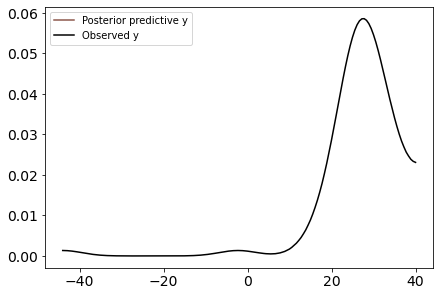

In [45]:
az.plot_ppc(fit_1, num_pp_samples=100)

### Plot test statistic for data and replicates
Something looks wrong here

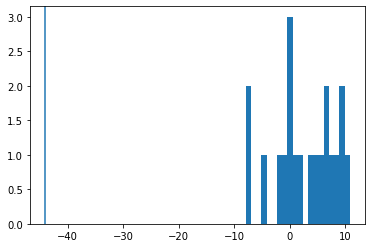

In [57]:
fig, ax = plt.subplots()
min_replicated = [posterior_predictive["y"][row_num].min() for row_num in row_nums]
min_observed = newcomb["y"].min()

ax.hist(min_replicated, bins=20)
ax.axvline(min_observed)